# Temperaturas Ciudades

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from datetime import datetime
from math import *
from util import *
from dateutil.relativedelta import relativedelta # $ pip install python-dateutil

plt.rcParams["figure.figsize"] = (16, 10)

In [2]:
#ciudades = df.query('city == "Akron" | city == "Cincinnati"')
#ciudad = df.query('city == "Lincoln"')

#dfjoinCiudades = df.query('city == "Cincinnati"').join(df.query('city == "Akron"').set_index("ordinal"), on='ordinal', lsuffix='_cin', rsuffix='_akr_')
#ciudad = df.query('city == "Lincoln"')
#df[df["date"] > datetime(1999,1,1)].pivot("city", "avg")

In [3]:
#Se predice por año, NO MES, se hace un avg del año

def dataFrameEnFecha(df, year, qtty):
    """ Devuelve un dataframe desde year hasta year+qtty
    """
    df = df[df['year'] >= year]
    return df[df['year'] < year+qtty]


def pasoComunGenDF(df, calAvg):
    listCities = list(set(df['city']))
    listCitiesQuery = list(set(df['city']))
    for i in range(len(listCitiesQuery)):
        listCitiesQuery[i] = '"' + listCitiesQuery[i] + '"'

    dicCities = {}
    for i in range(len(listCities)):
        #Genero un nuevo dataframe, calculo el avg anual y elimino las filas duplicadas del año y columna 'avg'
        dfCity = pd.DataFrame(df.query('city == ' + listCitiesQuery[i]))

        if(calAvg):
            listAvgYr = list(dfCity.groupby('year').apply(lambda x: x.sum()/12)['avg'])
            dfCity.drop_duplicates(subset='year', inplace=True)
            del dfCity['avg']
            dfCity['avg'] = listAvgYr

        #Agrego el dataframe a un dic
        dicCities[listCities[i]] = dfCity
    
    return dicCities

def genDFAvgYr(df):
    """ Devuelve un dataframe que tiene solo promedio anual
    """
    dicCities = pasoComunGenDF(df, True)
    valDf = list(dicCities.values())
    return pd.concat(valDf)


def generarDFXS(df, varList):
    """ Genero un dataframe con los xs para pasarle a la funcion
    """
    dicCities = pasoComunGenDF(df, False)

    #Genero el dataframe para retornar
    yearCol = list(set(df['year']))
    dfXs = pd.DataFrame()
    for k,v in dicCities.items():
        for c in varList:
            dfXs[c+ " " + k] = list(v[c])
    dfXs['year'] = yearCol
    
    return dfXs


def getListXS(df):
    temp=[]
    for row in df.iterrows():
        index, data = row
        temp.append(data.tolist())
    return [data for index, data in df.iterrows()]


def resolver(dfCity, dfe, yrP, qttyYrP, yrt, qttyYrT):
    #TRAINING
    dfCityT = dfCity.copy(deep=True)
    dfeT = dfE.copy(deep=True)
    #me quedo con los df de la fecha que necesito
    dfCityT = dataFrameEnFecha(dfCityT, yrP, qttyYrP)
    dfeT = dataFrameEnFecha(dfeT, yrP, qttyYrP)
    fechasT = list(dfeT['year'])

    #Con esto genero una lista con los x para pasarle a cml
    xsT = dfeT.values.tolist()
    ysT = list(dfCityT['avg'])
    funcion = lambda xs: [xs[i] for i in range(len(xs))] + [1]

    funCML = cml(funcion, xsT, ysT)
    resXST = [funCML(x) for x in xsT]

    #PREDICTION
    dfCityP = groupByCitiesW.get_group(listCitiesWest[0])
    dfeP = dfE.copy(deep=True)
    #me quedo con los df de la fecha que necesito
    dfCityP = dataFrameEnFecha(dfCityP, yrt, qttyYrT)
    dfeP = dataFrameEnFecha(dfeP, yrt, qttyYrT)
    fechasP = list(dfeP['year'])

    xsP = dfeP.values.tolist()
    ysP = list(dfCityP['avg'])
    resXSP = [funCML(x) for x in xsP]
    
    return (fechasT, xsT, ysT, resXST, fechasP, xsP, ysP, resXSP)

In [4]:
#LEVANTO DATOS
dfWest = pd.read_csv('data/CitiesWestChunk.csv', parse_dates = [0])
dfEast = pd.read_csv('data/CitiesEastChunk.csv', parse_dates = [0])
dfWest.sort_values(['date','country','city'], inplace = True)
dfEast.sort_values(['date','country','city'], inplace = True)

#ME QUEDO CON LOS DATOS DE FECHAS COMUNES EN TODAS
#Datos de 1849 a 2013
minWest = dfWest.groupby("city", as_index=False)["date"].aggregate(["min","max"])["min"].aggregate("max")
maxWest = dfWest.groupby("city", as_index=False)["date"].aggregate(["min","max"])["max"].aggregate("min")
minEast = dfEast.groupby("city", as_index=False)["date"].aggregate(["min","max"])["min"].aggregate("max")
maxEast = dfEast.groupby("city", as_index=False)["date"].aggregate(["min","max"])["max"].aggregate("min")
minTotal = max(minWest, minEast)
maxTotal = min(maxWest, maxWest)
dfWest = dfWest[dfWest['date'] >= minTotal]
dfWest = dfWest[dfWest['date'] < maxTotal]
dfEast = dfEast[dfEast['date'] >= minTotal]
dfEast = dfEast[dfEast['date'] < maxTotal]

#dfWest['ordinal']= dfWest['date'].apply(lambda x: x.toordinal())
dfWest["year"] = dfWest["date"].apply(lambda d: d.year)
#dfEast['ordinal']= dfEast['date'].apply(lambda x: x.toordinal())
dfEast["year"] = dfEast["date"].apply(lambda d: d.year)

#Genero promedio anual y quito promedio mensual
dfWest = genDFAvgYr(dfWest)
dfEast = genDFAvgYr(dfEast)

groupByCitiesW = dfWest.groupby('city')
groupByCitiesE = dfEast.groupby('city')

In [5]:
#funcion lineal cabeza, probar otras
#me hago un df para un ordinal tener todas las temperaturas de todas las ciudades (altitud tambien?)

In [27]:
#Para cada w in CitiesW, calcular(w, CitiesE)
#Para cada e in CitiesE, calcular(e, CitiesW)
listCitiesWest = list(set(dfWest['city']))
listCitiesEast = list(set(dfEast['city']))
listXs = ['avg','altitude','year']
dfW = generarDFXS(dfWest, listXs)
dfE = generarDFXS(dfEast, listXs)

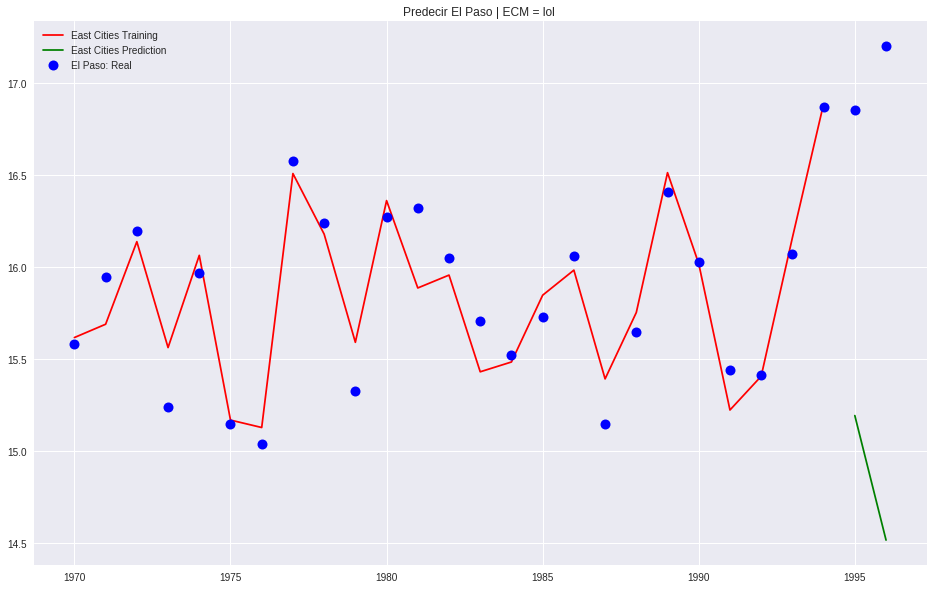

In [31]:
#TEST: tomo la ciudad idxCity del lado oeste e intento predecirla con todas las del este
idxCity = 10

dfCity = groupByCitiesW.get_group(listCitiesWest[idxCity])
dfe = dfE.copy(deep=True)

fechasT, xsT, ysT, resXST, fechasP, xsP, ysP, resXSP = resolver(dfCity, dfe, 1970, 25, 1995, 2)

plt.plot(fechasT, resXST, 'r', label='East Cities Training', color='red')
plt.plot(fechasP, resXSP, 'r', label='East Cities Prediction', color='green')

plt.plot(fechasT+fechasP, ysT+ysP, 'o', label=listCitiesWest[idxCity]+': Real', markersize=10, color='blue')

plt.title('{} | ECM = {} '.format("Predecir "+ listCitiesWest[idxCity], 'lol') )
plt.legend()
plt.show()

In [26]:
dfCity

,date,error,city,country,long,lat,season,hemisphere,altitude,year,avg
3541,1849-01-01,2.586,San Diego,United States,-117.77,32.95,4,1,26,1849,16.030167
3553,1850-01-01,2.598,San Diego,United States,-117.77,32.95,4,1,26,1850,15.553917
3565,1851-01-01,3.260,San Diego,United States,-117.77,32.95,4,1,26,1851,15.662583
3577,1852-01-01,2.565,San Diego,United States,-117.77,32.95,4,1,26,1852,16.063583
3589,1853-01-01,2.151,San Diego,United States,-117.77,32.95,4,1,26,1853,16.687667
3601,1854-01-01,2.070,San Diego,United States,-117.77,32.95,4,1,26,1854,16.114083
3613,1855-01-01,2.386,San Diego,United States,-117.77,32.95,4,1,26,1855,16.310083
3625,1856-01-01,3.278,San Diego,United States,-117.77,32.95,4,1,26,1856,15.749750
3637,1857-01-01,2.832,San Diego,United States,-117.77,32.95,4,1,26,1857,16.409250
3649,1858-01-01,3.035,San Diego,United States,-117.77,32.95,4,1,26,1858,15.961083
